In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.mixed_precision import set_global_policy, Policy

from sklearn.utils import class_weight

In [4]:
# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 30
TRAIN_DIR = "../../data5/train"
TEST_DIR = "../../data5/test"


# Create data generators with VGG16-specific preprocessing
# 2. Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Using the test set as "validation_data" (not ideal practice)
# but shown here due to the 2-folder constraint:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())

print("Number of classes:", num_classes)
print("Class labels:", class_labels)
# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.
Number of classes: 4
Class labels: ['Acne', 'Eczema', 'Infection', 'Malignant']


In [5]:
# 1) Load VGG16 pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# 2) Decide how many layers to freeze
# Freeze the initial layers
for layer in base_model.layers[:10]:
    layer.trainable = False

# 3) Build a new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = BatchNormalization()(x)  
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  
predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

58889256/58889256 [==============================] - 5s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/30
47/47 [==============================] - 1182s 25s/step - loss: 1.1529 - accuracy: 0.5599 - val_loss: 1.6494 - val_accuracy: 0.6005 - lr: 1.0000e-04
Epoch 2/30
47/47 [==============================] - 1253s 27s/step - loss: 0.8055 - accuracy: 0.6776 - val_loss: 1.1412 - val_accuracy: 0.6595 - lr: 1.0000e-04
Epoch 3/30
47/47 [==============================] - 1233s 26s/step - loss: 0.6902 - accuracy: 0.7263 - val_loss: 0.8095 - val_accuracy: 0.7003 - lr: 1.0000e-04
Epoch 4/30
47/47 [==============================] - 1173s 25s/step - loss: 0.6331 - accuracy: 0.7476 - val_loss: 0.6884 - val_accuracy: 0.7523 - lr: 1.0000e-04
Epoch 5/30
47/47 [==============================] - 1094s 23s/step - loss: 0.5658 - accuracy: 0.7781 - val_loss: 0.5826 - val_accuracy: 0.7830 - lr: 1.0000e-04
Epoch 6/30
47/47 [==============================] - 1081s 23s/step - loss: 0.5206 - accuracy: 0.7971 - val_loss: 0.8148 - val_accuracy: 0.6922 - lr: 1.0000e-04
Epoch 7/30
47/47 [======================

In [7]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
callbacks = [early_stopping, lr_scheduler, checkpoint]

In [8]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


21/21 [==============================] - 277s 13s/step - loss: 0.5767 - accuracy: 0.7900
Test Loss: 0.576683521270752, Test Accuracy: 0.7899844646453857


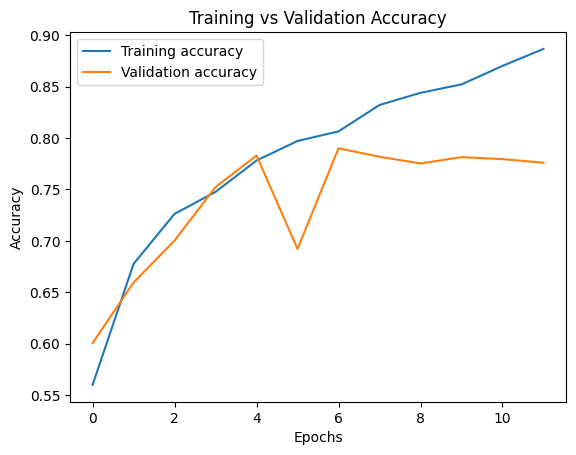

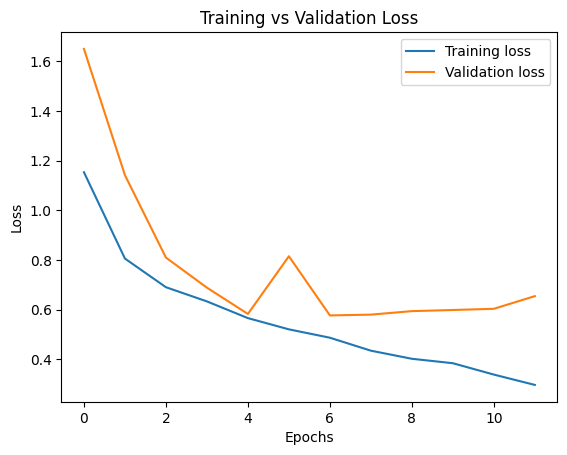

In [9]:
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history, metrics=["accuracy", "loss"])

21/21 [==============================] - 289s 14s/step

Classification Report:
              precision    recall  f1-score   support

        Acne       0.84      0.91      0.87       626
      Eczema       0.73      0.76      0.74       650
   Infection       0.70      0.63      0.66       650
   Malignant       0.89      0.88      0.88       650

    accuracy                           0.79      2576
   macro avg       0.79      0.79      0.79      2576
weighted avg       0.79      0.79      0.79      2576

Confusion Matrix:
[[569  10  30  17]
 [ 34 491 105  20]
 [ 60 146 408  36]
 [ 13  26  39 572]]


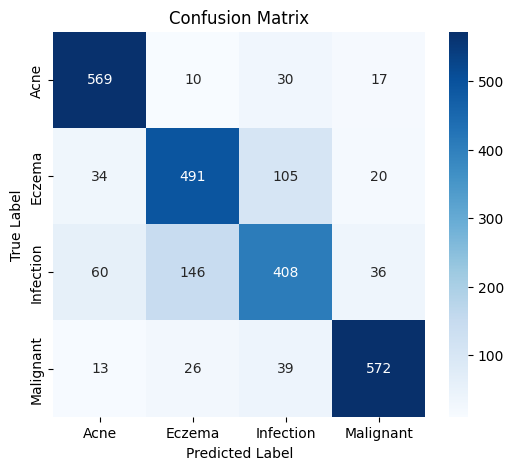

In [11]:
import seaborn as sns 
# Predict class probabilities
y_pred_probs = model.predict(test_generator)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the test generator
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Macro-average ROC AUC: 0.9436930708773145
Micro-average ROC AUC: 0.9489690931902061


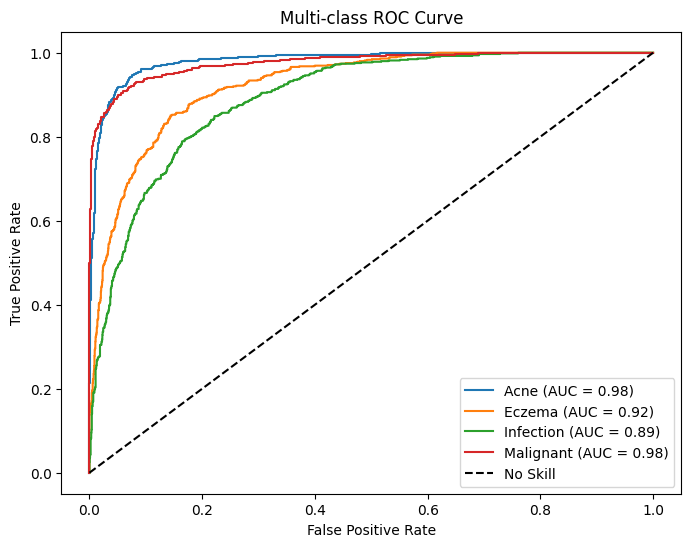

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
y_true_indices = test_generator.classes

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [13]:
model.save("../../models/hybrid_model_vgg16_beforeFinTune_new128.keras")

In [22]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2

# Fine-tuning learning rate
FINE_TUNE_LEARNING_RATE = 1e-5

# Add L2 regularization to the existing dense output layer
# Access the last dense layer and modify its kernel regularizer
for layer in model.layers:
    if isinstance(layer, Dense):
        layer.kernel_regularizer = l2(0.01)  # Apply L2 regularization

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,  # Fine-tuning typically requires fewer epochs
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/15
47/47 [==============================] - 1243s 26s/step - loss: 1.2293 - accuracy: 0.5103 - val_loss: 0.7992 - val_accuracy: 0.7209 - lr: 1.0000e-05
Epoch 2/15
47/47 [==============================] - 1196s 25s/step - loss: 0.8067 - accuracy: 0.6909 - val_loss: 0.7766 - val_accuracy: 0.7457 - lr: 1.0000e-05
Epoch 3/15
47/47 [==============================] - 1335s 29s/step - loss: 0.6985 - accuracy: 0.7451 - val_loss: 0.7097 - val_accuracy: 0.7671 - lr: 1.0000e-05
Epoch 4/15
47/47 [==============================] - 1238s 26s/step - loss: 0.6310 - accuracy: 0.7871 - val_loss: 0.6819 - val_accuracy: 0.7877 - lr: 1.0000e-05
Epoch 5/15
47/47 [==============================] - 1304s 28s/step - loss: 0.5824 - accuracy: 0.8073 - val_loss: 0.7519 - val_accuracy: 0.7772 - lr: 1.0000e-05
Epoch 6/15
47/47 [==============================] - 1228s 26s/step - loss: 0.5570 - accuracy: 0.8160 - val_loss: 0.6713 - val_accuracy: 0.7873 - lr: 1.0000e-05
Epoch 7/15
47/47 [======================

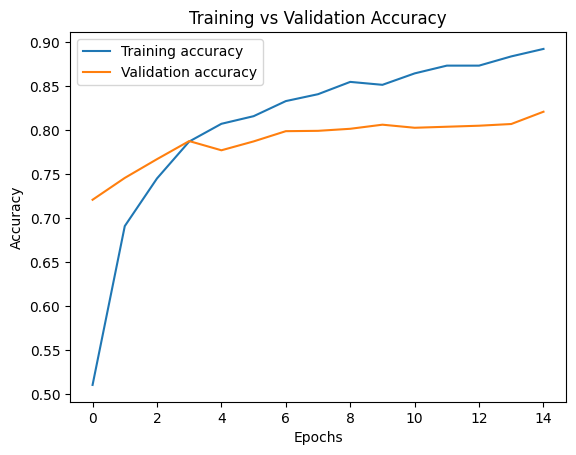

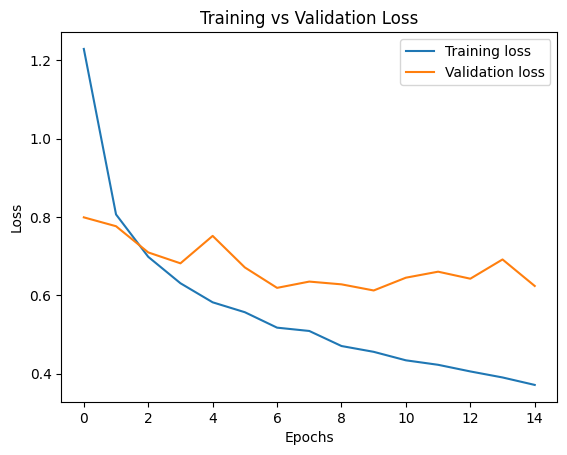

In [23]:
def plot_training_results(history, metrics=["accuracy", "loss"]):
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_training_results(history_finetune, metrics=["accuracy", "loss"])

21/21 [==============================] - 313s 15s/step

Classification Report:
              precision    recall  f1-score   support

        Acne       0.90      0.89      0.90       626
      Eczema       0.78      0.74      0.76       650
   Infection       0.68      0.79      0.73       650
   Malignant       0.96      0.86      0.91       650

    accuracy                           0.82      2576
   macro avg       0.83      0.82      0.82      2576
weighted avg       0.83      0.82      0.82      2576

Confusion Matrix:
[[558  18  43   7]
 [ 18 484 141   7]
 [ 31  98 511  10]
 [ 11  18  59 562]]


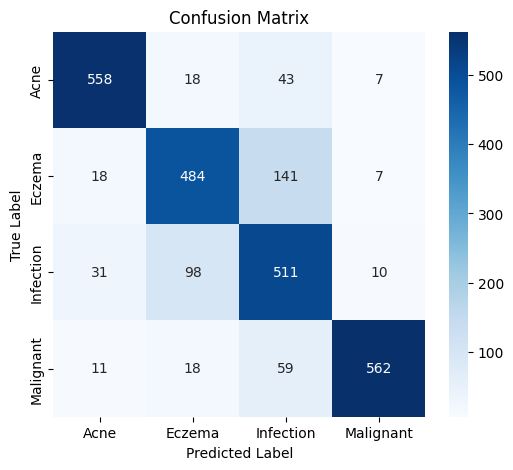

In [24]:
import seaborn as sns 
# Predict class probabilities
y_pred_probs = model.predict(test_generator)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the test generator
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
train_loss = history.history['loss']
train_acc  = history.history['accuracy']
val_loss   = history.history['val_loss']
val_acc    = history.history['val_accuracy']

epochs_range = range(len(train_loss))

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss,   label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc,   label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


In [25]:
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


Train Loss: 0.3333703279495239
Train Accuracy: 0.9088181257247925


In [41]:
# 6. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Val Loss:", test_loss)
print("Val Accuracy:", test_accuracy)

21/21 [==============================] - 667s 31s/step - loss: 0.6240 - accuracy: 0.8210
Val Loss: 0.6240428686141968
Val Accuracy: 0.8210403919219971


In [27]:
model.save("../../models/hybrid_model_vgg16_new128_afterFineTune.keras")

Macro-average ROC AUC: 0.9523064022557917
Micro-average ROC AUC: 0.957392348184548


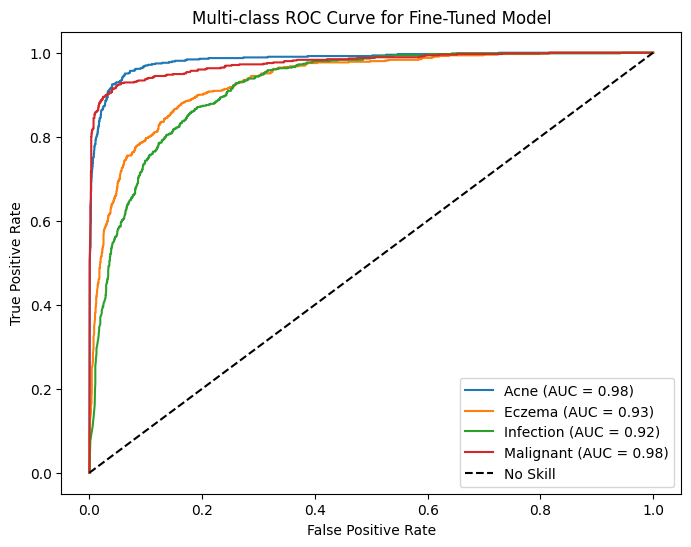

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
y_true_indices = test_generator.classes

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve for Fine-Tuned Model')
plt.legend(loc='lower right')
plt.show()

In [29]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle

# Constants
BATCH_SIZE = 128  # Replace with your actual batch size
MODEL_SAVE_PATH = '../../models/hybrid_rf_vgg16_model_128.pkl'  # Path to save the model

# Function to Extract Features and Labels
def extract_features_and_labels(generator, base_model, batch_size):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        features.append(base_model.predict(batch_images, verbose=0))  # Extract features
        labels.append(batch_labels)
        # Stop when all samples are processed
        if len(features) * batch_size >= generator.samples:
            break
    features = np.vstack(features)  # Stack features vertically
    labels = np.vstack(labels)      # Stack labels vertically
    return features, labels

# Step 1: Extract Features and Labels from Training Data
print("Extracting features and labels for training...")
train_features, train_labels = extract_features_and_labels(train_generator, base_model, BATCH_SIZE)

# Extract Features and Labels from Test Data
print("Extracting features and labels for testing...")
test_features, test_labels = extract_features_and_labels(test_generator, base_model, BATCH_SIZE)

# Step 2: Convert One-Hot Encoded Labels to Integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Step 3: Flatten Features for Random Forest
print("Flattening features for Random Forest...")
X_train = train_features.reshape(train_features.shape[0], -1)
X_test = test_features.reshape(test_features.shape[0], -1)

# Step 4: Define and Train Random Forest with Grid Search
print("Training Random Forest with Grid Search...")
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, train_labels)

# Get the best model from grid search
best_rf = grid_search.best_estimator_

# Step 5: Evaluate the Model
print("Evaluating the model...")
y_pred = best_rf.predict(X_test)

print("Classification Report:")
print(classification_report(test_labels, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

# Step 6: Save the Model
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully.")


Extracting features and labels for training...
Extracting features and labels for testing...
Flattening features for Random Forest...
Training Random Forest with Grid Search...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       626
           1       0.81      0.63      0.71       650
           2       0.59      0.84      0.69       650
           3       0.95      0.85      0.90       650

    accuracy                           0.79      2576
   macro avg       0.82      0.79      0.80      2576
weighted avg       0.82      0.79      0.80      2576

Confusion Matrix:
[[530   7  82   7]
 [ 18 412 211   9]
 [ 24  72 544  10]
 [  5  15  79 551]]
Saving the model to ../../models/hybrid_rf_vgg16_model_128.pkl...
Model saved successfully.


In [ ]:
from sklearn.decomposition import PCA
import joblib

pca = PCA(n_components=128)  # Dimensionality reduction

# Flatten the data
X_train_flat = train_features.reshape(X_train.shape[0], -1)
X_test_flat = test_features.reshape(X_test.shape[0], -1)
train_features_pca = pca.fit_transform(X_train_flat)
val_features_pca = pca.transform(X_test_flat)

pca_model_path = "../../models/vgg16_128_pca_model.pkl"
joblib.dump(pca, pca_model_path)

['../../models/vgg7030_pca_model.pkl']

In [30]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle

# Constants
BATCH_SIZE = 128 
MODEL_SAVE_PATH = '../../models/hybrid_knn_vgg16_model_128.pkl' 

# Function to Extract Features and Labels
def extract_features_and_labels(generator, base_model, batch_size):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        features.append(base_model.predict(batch_images, verbose=0))  
        labels.append(batch_labels)
        # Stop when all samples are processed
        if len(features) * batch_size >= generator.samples:
            break
    features = np.vstack(features)  
    labels = np.vstack(labels)     
    return features, labels

# Step 1: Extract Features and Labels from Training Data
print("Extracting features and labels for training...")
train_features, train_labels = extract_features_and_labels(train_generator, base_model, BATCH_SIZE)

# Extract Features and Labels from Test Data
print("Extracting features and labels for testing...")
test_features, test_labels = extract_features_and_labels(test_generator, base_model, BATCH_SIZE)

# Step 2: Convert One-Hot Encoded Labels to Integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Step 3: Flatten Features for KNN
print("Flattening features for KNN...")
X_train = train_features.reshape(train_features.shape[0], -1)
X_test = test_features.reshape(test_features.shape[0], -1)

# Step 4: Define and Train KNN with Grid Search
print("Training KNN with Grid Search...")
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, train_labels)

# Get the best model from grid search
best_knn = grid_search.best_estimator_

# Step 5: Evaluate the Model
print("Evaluating the model...")
y_pred = best_knn.predict(X_test)

print("Classification Report:")
print(classification_report(test_labels, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

# Step 6: Save the Model
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_knn, file)

print("Model saved successfully.")


Extracting features and labels for training...
Extracting features and labels for testing...
Flattening features for KNN...
Training KNN with Grid Search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       626
           1       0.72      0.75      0.73       650
           2       0.65      0.75      0.70       650
           3       0.94      0.86      0.90       650

    accuracy                           0.80      2576
   macro avg       0.81      0.80      0.80      2576
weighted avg       0.81      0.80      0.80      2576

Confusion Matrix:
[[517  32  70   7]
 [ 15 486 131  18]
 [ 18 132 490  10]
 [  2  28  59 561]]
Saving the model to ../../models/hybrid_knn_vgg16_model_128.pkl...
Model saved successfully.


In [35]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Constants
BATCH_SIZE = 128
MODEL_SAVE_PATH = '../../models/hybrid_rf_newmethod_vgg16_model_128.pkl'

# Step 0: Build a base VGG model that outputs 128-dim features
def create_base_model_128():
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = vgg.output               # shape: (None, 7, 7, 512)
    x = Flatten()(x)            # shape: (None, 25088)
    x = Dense(128, activation='relu')(x)  # Now shape: (None, 128)
    base_model = Model(inputs=vgg.input, outputs=x)
    return base_model

base_model = create_base_model_128()

# Function to Extract Features and Labels
def extract_features_and_labels(generator, base_model, batch_size):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        # Extract 128-d features from the new base_model
        batch_feats = base_model.predict(batch_images, verbose=0)
        features.append(batch_feats)
        labels.append(batch_labels)
        
        # Stop when all samples are processed
        if len(features) * batch_size >= generator.samples:
            break

    features = np.vstack(features)  # shape: (num_samples, 128)
    labels = np.vstack(labels)      # shape: (num_samples, num_classes)
    return features, labels

# 1. Extract Features and Labels from Training Data
print("Extracting features and labels for training...")
train_features, train_labels = extract_features_and_labels(train_generator, base_model, BATCH_SIZE)

# 2. Extract Features and Labels from Test Data
print("Extracting features and labels for testing...")
test_features, test_labels = extract_features_and_labels(test_generator, base_model, BATCH_SIZE)

# Convert One-Hot Encoded Labels to Integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Because our base_model is already outputting shape (N, 128),
# we do NOT need an additional reshape. But let's confirm:
print("train_features shape:", train_features.shape)  # (N, 128)
print("test_features shape:", test_features.shape)    # (M, 128)

# 3. Define and Train Random Forest with Grid Search
print("Training Random Forest with Grid Search...")
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(train_features, train_labels)

# Get the best model from grid search
best_rf = grid_search.best_estimator_

# 4. Evaluate the Model
print("Evaluating the model...")
y_pred = best_rf.predict(test_features)

print("Classification Report:")
print(classification_report(test_labels, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

# 5. Save the Model
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully.")


Extracting features and labels for training...
Extracting features and labels for testing...
train_features shape: (5999, 128)
test_features shape: (2576, 128)
Training Random Forest with Grid Search...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       626
           1       0.51      0.56      0.53       650
           2       0.43      0.22      0.29       650
           3       0.63      0.76      0.69       650

    accuracy                           0.56      2576
   macro avg       0.54      0.56      0.54      2576
weighted avg       0.54      0.56      0.53      2576

Confusion Matrix:
[[433  83  57  53]
 [110 364  80  96]
 [135 228 140 147]
 [ 58  44  52 496]]
Saving the model to ../../models/hybrid_rf_newmethod_vgg16_model_128.pkl...
Model saved successfully.


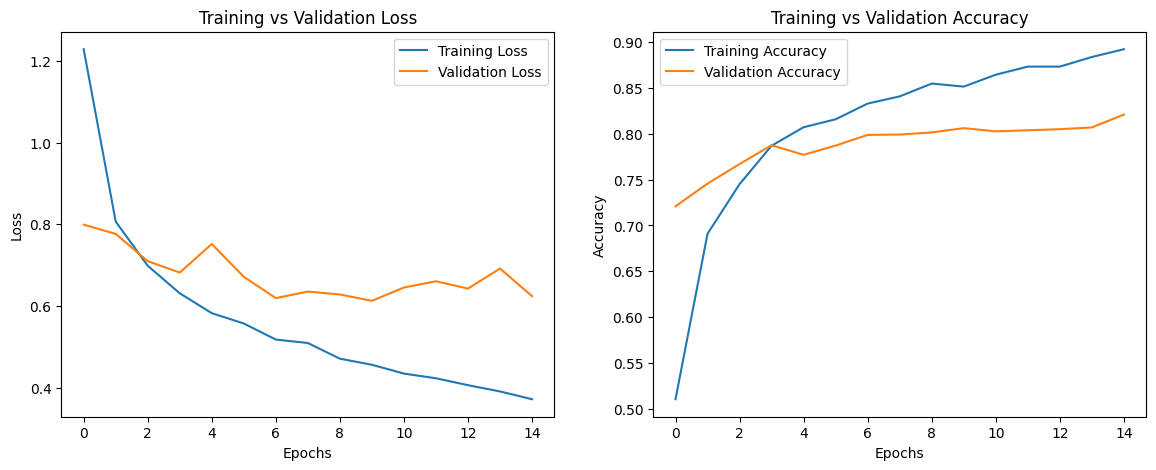

In [36]:
train_loss = history_finetune.history['loss']
train_acc  = history_finetune.history['accuracy']
val_loss   = history_finetune.history['val_loss']
val_acc    = history_finetune.history['val_accuracy']

epochs_range = range(len(train_loss))

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss,   label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc,   label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [37]:
import tensorflow as tf; print(tf.__version__)

2.15.0


In [39]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle

# Constants
BATCH_SIZE = 128  # Replace with your actual batch size
MODEL_SAVE_PATH = '../../models/hybrid_rf_feature_vgg16_model_128.pkl'  # Path to save the model

# Function to Extract Features and Labels
def extract_features_and_labels(generator, base_model, batch_size):
    features = []
    labels = []
    for batch_images, batch_labels in generator:
        # Extract features using the base CNN model
        batch_features = base_model.predict(batch_images, verbose=0)
        features.append(batch_features)
        labels.append(batch_labels)

        # Stop when all samples are processed
        if len(features) * batch_size >= generator.samples:
            break

    # Stack features and labels
    features = np.vstack(features)  # Combine features vertically
    labels = np.vstack(labels)      # Combine labels vertically
    return features, labels

# Step 1: Extract Features and Labels from Training Data
print("Extracting features and labels for training...")
train_features, train_labels = extract_features_and_labels(train_generator, base_model, BATCH_SIZE)

# Extract Features and Labels from Test Data
print("Extracting features and labels for testing...")
test_features, test_labels = extract_features_and_labels(test_generator, base_model, BATCH_SIZE)

# Debug: Print feature shapes
print("Train features shape before flattening:", train_features.shape)
print("Test features shape before flattening:", test_features.shape)

# Step 2: Convert One-Hot Encoded Labels to Integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

# Step 3: Flatten Features for Random Forest
print("Flattening features for Random Forest...")
X_train = train_features.reshape(train_features.shape[0], -1)
X_test = test_features.reshape(test_features.shape[0], -1)

# Debug: Print flattened feature shapes
print("Flattened train features shape:", X_train.shape)
print("Flattened test features shape:", X_test.shape)

# Step 4: Define and Train Random Forest with Grid Search
print("Training Random Forest with Grid Search...")
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, train_labels)

# Get the best model from grid search
best_rf = grid_search.best_estimator_

# Step 5: Evaluate the Model
print("Evaluating the model...")
y_pred = best_rf.predict(X_test)

print("Classification Report:")
print(classification_report(test_labels, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred))

# Step 6: Save the Model
print(f"Saving the model to {MODEL_SAVE_PATH}...")
with open(MODEL_SAVE_PATH, 'wb') as file:
    pickle.dump(best_rf, file)

print("Model saved successfully.")


Extracting features and labels for training...
Extracting features and labels for testing...
Train features shape before flattening: (5999, 128)
Test features shape before flattening: (2576, 128)
Flattening features for Random Forest...
Flattened train features shape: (5999, 128)
Flattened test features shape: (2576, 128)
Training Random Forest with Grid Search...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Evaluating the model...
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       626
           1       0.49      0.56      0.52       650
           2       0.41      0.21      0.28       650
           3       0.64      0.73      0.68       650

    accuracy                           0.54      2576
   macro avg       0.52      0.54      0.52      2576
weighted avg       0.52      0.54      0.52      2576

Confusion Matrix:
[[423  98  55  50]
 [107 363  96  84]
 [146 232 134 138]
 [ 86  49  38 4

In [40]:
print("Shape of training features (X_train):", X_train.shape)


Shape of training features (X_train): (5999, 128)
